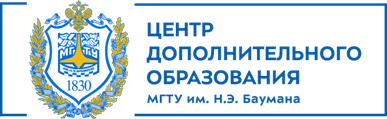
# Цикл обработки данных на сервере PostgreSQL на языке Python с помощью библиотеки psycopg2
## Вступление
На этом занятии мы разберем, как создать и изменить базу данных PostgreSQL на Python с помощью библиотеки psycopg2.

Ключевая идея использования библиотеки psycopg2 заключается в том, что она берет ваши вручную созданные SQL-запросы и выполняет их для базы данных. То есть psycopg2 представляет собой реализайи драйвера базы данных PostgreSQL для языка Python.

## Создание базы данных и ее таблиц
Создадим простую базу данных с резултатами численного эксперимента, состоящую из двух таблиц: «Эксперимент» и «Измерения».
Проводится серия экспериментов, для каждого из которых измеряется один входной параметр **X** и один выходной параметр **Y**.
Каждое измерение относится к одному эксперименту, в одном эксперименте может содержаться **N** измерений (много экспериментальныйх точек). Эта связь реализуется с использованием ***id*** в качестве первичного ключа экспериментов и ***test_id*** в качестве внешнего ключа измеренных в экспериментах точек.
Теперь давайте посмотрим на полный сценарий создания базы данных и ее таблиц, за которым следует объяснение кода.

In [1]:
# Загружаем необходимые библиотеки
from configparser import ConfigParser
import psycopg2
from typing import Dict


def load_connection_info(
    ini_filename: str
) -> Dict[str, str]:
    parser = ConfigParser()
    parser.read(ini_filename)
    # Создадим словарь переменных, хранящихся в разделе "postgresql" файла .ini
    conn_info = {param[0]: param[1] for param in parser.items("postgresql")}
    return conn_info

def create_db(
    conn_info: Dict[str, str],
) -> None:
    # Подключаемся к PostgreSQL с пользователем, загруженным из файла .ini
    psql_connection_string = f"host={conn_info['host']} port={conn_info['port']} user={conn_info['user']} password={conn_info['password']}"
    conn = psycopg2.connect(psql_connection_string)
    cur = conn.cursor()
    # операция "CREATE DATABASE" требует автоматического завершения транзакции (commits)
    conn.autocommit = True
    sql_query = f"CREATE DATABASE {conn_info['database']}"

    try:
        cur.execute(sql_query)
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        print(f"Query: {cur.query}")
        cur.close()
    else:
        # Возвращаем отмену автозавершения транзакций
        conn.autocommit = False


def create_table(
    sql_query: str, 
    conn: psycopg2.extensions.connection, 
    cur: psycopg2.extensions.cursor
) -> None:
    try:
        # Выполняем 
        cur.execute(sql_query)
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        print(f"Query: {cur.query}")
        conn.rollback()
        cur.close()
    else:
        # Чтобы изменения вступили в силу, их необходимо зафиксировать в базе данных
        conn.commit()


if __name__ == "__main__":
    # host, port, database, user, password
    conn_info = load_connection_info("db.ini")

    # Создаем желаемую базу данных
    create_db(conn_info)

    # Создаем подключение к созданной базе данных
    connection = psycopg2.connect(**conn_info)
    cursor = connection.cursor()

    # Создание таблицы "Эксперимент" (test)
    test_sql = """
        CREATE TABLE test (
            id SERIAL PRIMARY KEY,
            description VARCHAR(100) UNIQUE NOT NULL
        )
    """
    create_table(test_sql, connection, cursor)


    # Создание таблицы "Измерения" (datapoint)
    datapoint_sql = """
        CREATE TABLE datapoint (
            id SERIAL PRIMARY KEY,
            X NUMERIC,
            Y NUMERIC,
            test_id SERIAL REFERENCES test(id)
        )
    """
    create_table(datapoint_sql, connection, cursor)

    # Аккураа-а-аатно закрываем соединение с базой данных
    connection.close()
    cursor.close()

(если вы не знакомы с условием if __name__ == "__main__", оно проверяет, что выполняемый скрипт является текущим скриптом)

По сути, этот скрипт делает следующее:

- Загружает информацию о подключении к базе данных из файла .ini;
- Подключается к PostgreSQL;
- Создает базу «экспериментов»;
- Подключается к вновь созданной базе данных;
- Создает таблицу экспериментов
- Создает таблицу точек данных
Содержимое файла .ini (файл db.ini должен находиться в той же папке, из которой работает приложение Python или Jupyter Notebook) - это просто набор переменных для подключения к базе данных.

[postgresql]
- host=localhost
- port=5433
- database=testdb
- user=postgres
- password=123


Мы выносим их в отдельный конфигурационный файл чтобы обеспечить переносимость приложения, вместо того, чтобы жестко закодировать их в коде Python. Хотя, поскольку это локальная база данных, в нее вынесены мои учетные данные.

После загрузки этой информации с помощью функции load_connection_info в качестве словаря мы подключаемся к PostgreSQL. Поскольку базы данных еще нет, мы подключаемся к самому движку. Создание обрабатывается функцией create_db. 
psycopg2.connect возвращает соединение между Python и PostgreSQL, из которого мы создаем курсор. Курсоры создаются для выполнения кода в PostgreSQL.

После этого, все еще находясь в create_db, мы execute запрос на создание базы данных, передав ему строку с правильным кодом SQL. Он заключен в блок try / except / else на случай, если что-то пойдет не так. Обычно мы сначала выполняем запрос, а затем фиксируем его в базе данных, но операторы CREATE DATABASE требуют, чтобы фиксация была автоматической, поэтому мы используем conn.autocommit в create_db.

Итак, база данных для хранения экспериментальных данных создана, следующим шагом будет создание таблиц «test» и «datapoint». Сначала подключиvcz к вновь созданной базе данных и создаlbv новый курсор в строке. Вместо того, чтобы передавать каждый аргумент отдельно (хост, база данных, пользователь и пароль), мы используем оператор ** для распаковки каждой пары ключ-значение на своем собственный.

Затем мы создаем таблицы «test» и «datapoint». Мы пишем необходимые SQL-запросы и вызываем функцию create_table. 
create_table просто выполняет и фиксирует запросы, заключенные в блок try / except / else. Если ничего плохого не происходит, изменения фиксируются в базе данных внутри блока else, в противном случае исключение и запрос выводятся в блоке except. В случае возникновения исключения мы также откатываем все изменения, которые не были зафиксированы.

В самом конце скрипта закрываем все активные соединения и курсоры.
## Заполнение базы данных
На этом этапе вся инфраструктура подготовлена, и мы можем перейти к заполнению экспериментальных данных.

In [2]:
from configparser import ConfigParser
import psycopg2
import psycopg2.extras as psql_extras
import pandas as pd
from typing import Dict


def load_connection_info(
    ini_filename: str
) -> Dict[str, str]:
    parser = ConfigParser()
    parser.read(ini_filename)
    # Создадим словарь переменных, хранящихся в разделе "postgresql" файла .ini
    conn_info = {param[0]: param[1] for param in parser.items("postgresql")}
    return conn_info


def insert_data(
    query: str,
    conn: psycopg2.extensions.connection,
    cur: psycopg2.extensions.cursor,
    df: pd.DataFrame,
    page_size: int
) -> None:
    data_tuples = [tuple(row.to_numpy()) for index, row in df.iterrows()]

    try:
        psql_extras.execute_values(
            cur, query, data_tuples, page_size=page_size)
        print("Запрос:", cur.query)

    except Exception as error:
        print(f"{type(error).__name__}: {error}")
        print("Запрос:", cur.query)
        conn.rollback()
        cur.close()

    else:
        conn.commit()


if __name__ == "__main__":
    # host, database, port, user, password
    conn_info = load_connection_info("db.ini")
    # Подключаемся к базе данных экспериментов
    connection = psycopg2.connect(**conn_info)
    cursor = connection.cursor()

    # Заносим данные в список экспериментов:
    test_df = pd.DataFrame({
        "id": [1, 2, 3], 
        "description": ["First test", "Second test", "Third test"]
    })
    house_query = "INSERT INTO test(id, description) VALUES %s"
    insert_data(house_query, connection, cursor, test_df, 100)

    # 
    datapoint_df = pd.DataFrame({
        "id": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 
        "x": [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
        "y": [1.0, 1.4, 1.8, 2.2, 2.6, 3.0, 1.0, 1.04, 1.16, 1.36, 1.64, 2.0, 1.0, 1.1987, 1.3894, 1.5646, 1.7174, 1.8415],
        "test_id": [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3]
    })
    datapoint_query = "INSERT INTO datapoint(id, x, y, test_id) VALUES %s"
    insert_data(datapoint_query, connection, cursor, datapoint_df, 100)

    # Close all connections to the database
    connection.close()
    cursor.close()

Запрос: b"INSERT INTO test(id, description) VALUES (1,'First test'),(2,'Second test'),(3,'Third test')"
Запрос: b'INSERT INTO datapoint(id, x, y, test_id) VALUES (1.0,0.0,1.0,1.0),(2.0,0.2,1.4,1.0),(3.0,0.4,1.8,1.0),(4.0,0.6,2.2,1.0),(5.0,0.8,2.6,1.0),(6.0,1.0,3.0,1.0),(7.0,0.0,1.0,2.0),(8.0,0.2,1.04,2.0),(9.0,0.4,1.16,2.0),(10.0,0.6,1.36,2.0),(11.0,0.8,1.64,2.0),(12.0,1.0,2.0,2.0),(13.0,0.0,1.0,3.0),(14.0,0.2,1.1987,3.0),(15.0,0.4,1.3894,3.0),(16.0,0.6,1.5646,3.0),(17.0,0.8,1.7174,3.0),(18.0,1.0,1.8415,3.0)'


Наша цель - вставить pandas DataFrames в базу данных. Однако, даже если мы вставляем только несколько строк в каждую таблицу, способ написания функции insert_data позволяет вставлять DataFrames с сотнями строк в базу данных. Это достигается за счет использования execute_values вместо базовой функции execute, что позволяет вставлять пакеты в виде одного гигантского запроса. Независимо от количества строк в DataFrame, execute_values будет вставлять только 100 строк за раз, указанное значение page_size.

Разберем выполненные действия:

- Подключились к базе данных;
- Создали DataFrame для данных экспериментов;
- Вставили в таблицу данные по экспериментам;
- Создали DataFrame для экспериментальных данных;
- Записали экспериментальные данные а таблицу datapoint.

Основная логика при работе с psycopg2 заключается в трио действий выполнить / зафиксировать / откатить. Сначала вы выполняете SQL-запрос, и, если все идет хорошо, вы фиксируете изменения, в противном случае вы откатываете изменения. Что бы вы ни пытались сделать, ваши действия включают выполнение, фиксацию и откат.

Всего два примечания, которые следует учитывать при вставках:

execute_values принимает данные только как кортежи, отсюда и преобразование в строке 15; а также
Строка запроса должна иметь %s, чтобы execute_values мог заменить кортеж данных в этой строке запроса (строки 54 и 63). Если вы не знакомы с этим синтаксисом для замены строк, ознакомьтесь с этой статьей, чтобы узнать больше.
## Извлечение и использование данных

Наконец, мы можем написать несколько запросов SELECT для извлечения данных!


In [3]:
from configparser import ConfigParser
import psycopg2
import psycopg2.extras as psql_extras
import pandas as pd
from typing import Dict, List


def load_connection_info(
    ini_filename: str
) -> Dict[str, str]:
    parser = ConfigParser()
    parser.read(ini_filename)
    # Создадим словарь переменных, хранящихся в разделе "postgresql" файла .ini
    conn_info = {param[0]: param[1] for param in parser.items("postgresql")}
    return conn_info


def get_column_names(
    table: str,
    cur: psycopg2.extensions.cursor
) -> List[str]:
    cursor.execute(
        f"SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{table}';")
    col_names = [result[0] for result in cursor.fetchall()]
    return col_names


def get_data_from_db(
    query: str,
    conn: psycopg2.extensions.connection,
    cur: psycopg2.extensions.cursor,
    df: pd.DataFrame,
    col_names: List[str]
) -> pd.DataFrame:
    try:
        cur.execute(query)
        while True:
            # Разберем следующие 100 строк таблицы
            query_results = cur.fetchmany(100)
            # Если возвращается пустой список, значит, мы достигли конца результатов
            if query_results == list():
                break

            # Создаем список словарей, в котором каждый словарь представляет собой одну строку
            results_mapped = [
                {col_names[i]: row[i] for i in range(len(col_names))}
                for row in query_results
            ]

            # Добавьте извлеченные строки во фрейм данных
            df = df.append(results_mapped, ignore_index=True)

        return df

    except Exception as error:
        print(f"{type(error).__name__}: {error}")
        print("Query:", cur.query)
        conn.rollback()


if __name__ == "__main__":
    # host, port, database, user, password
    conn_info = load_connection_info("db.ini")
    # Подключаемся к БД экспериментов
    connection = psycopg2.connect(**conn_info)
    cursor = connection.cursor()

    # Имена столбцов датафрейма должны совпадать с именами столбцов, возвращаемыми SQL-запросом
    col_names = get_column_names("test", cursor)
    # Создаем пустой фрейм данных, в котором будут содержаться возвращаемые данные
    house_df = pd.DataFrame(columns=col_names)
    query = "SELECT * from test;"
    test_df = get_data_from_db(query, connection, cursor, test_df, col_names)
    print(test_df)

    # Имена столбцов датафрейма должны совпадать с именами столбцов, возвращаемыми SQL-запросом
    col_names = get_column_names("datapoint", cursor)
    # Создаем пустой фрейм данных, в котором будут содержаться возвращаемые данные
    datapoint_df = pd.DataFrame(columns=col_names)
    query = "SELECT * from datapoint;"
    datapoint_df = get_data_from_db(query, connection, cursor, datapoint_df, col_names)
    print(datapoint_df)

    # Имена столбцов датафрейма должны совпадать с именами столбцов, возвращаемыми SQL-запросом
    col_names = ["Test", "ValueX", "ValueY"]
    # Create an empty DataFrame that will have the returned data
    test_data_df = pd.DataFrame(columns=col_names)
    query = """
        SELECT test.description AS Test, datapoint.x AS ValueX, datapoint.y AS ValueY
        FROM datapoint 
        INNER JOIN test
        ON datapoint.test_id = test.id
        ORDER BY Test;
        """
    test_data_df = get_data_from_db(query, connection, cursor, test_data_df, col_names)
    print(test_data_df)
    
    # Close all connections to the database
    connection.close()
    cursor.close()

   id  description
0   1   First test
1   2  Second test
2   3   Third test
3   1   First test
4   2  Second test
5   3   Third test
    id    x       y test_id
0    1  0.0     1.0       1
1    2  0.2     1.4       1
2    3  0.4     1.8       1
3    4  0.6     2.2       1
4    5  0.8     2.6       1
5    6  1.0     3.0       1
6    7  0.0     1.0       2
7    8  0.2    1.04       2
8    9  0.4    1.16       2
9   10  0.6    1.36       2
10  11  0.8    1.64       2
11  12  1.0     2.0       2
12  13  0.0     1.0       3
13  14  0.2  1.1987       3
14  15  0.4  1.3894       3
15  16  0.6  1.5646       3
16  17  0.8  1.7174       3
17  18  1.0  1.8415       3
           Test ValueX  ValueY
0    First test    0.0     1.0
1    First test    0.2     1.4
2    First test    0.4     1.8
3    First test    0.6     2.2
4    First test    0.8     2.6
5    First test    1.0     3.0
6   Second test    0.0     1.0
7   Second test    0.2    1.04
8   Second test    0.4    1.16
9   Second test    0.6   

C:\Users\acer\AppData\Local\Temp\ipykernel_5156\3467713394.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_mapped, ignore_index=True)
C:\Users\acer\AppData\Local\Temp\ipykernel_5156\3467713394.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_mapped, ignore_index=True)
C:\Users\acer\AppData\Local\Temp\ipykernel_5156\3467713394.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(results_mapped, ignore_index=True)


Мы рассмотрели выполнение, фиксацию и откат, но есть еще одна общая функция, используемая при работе с psycopg2: fetch. Когда выполненный запрос возвращает некоторые данные, выборка - это то, как мы получаем эти данные. И точно так же, как у execute есть вариации, у fetch тоже есть вариации. Мы можем использовать fetchone, чтобы получить следующую строку данных, fetchall, чтобы получить сразу все строки, или fetchmany, чтобы получить пакет строк за раз.

В этом случае мы используем fetchmany. Опять же, в каждой таблице всего несколько строк, но я написал код таким образом, чтобы вы могли легко вернуться к нему в будущем, если это необходимо. Как и в случае с execute_values, с помощью fetchmany вы можете сбалансировать затраты памяти на работу с большими объемами данных и производительность кода.

И так же, как мы вставили данные из DataFrames, теперь мы хотим извлечь данные в DataFrames. Для этого мы начинаем с создания пустого DataFrame, в котором указаны только имена его столбцов. Это важно, потому что эти имена должны совпадать с именами столбцов в результатах запроса.

Внутри get_data_from_db (строки с 28 по 58) мы выполняем SQL-запрос и продолжаем извлекать следующие 100 строк, пока остаются строки. Конечно, в этом случае мы получаем только один раз за запрос. Для каждой строки полученного пакета мы сохраняем ее в списке словарей, которые сопоставляют столбцы со значениями, то есть каждый словарь представляет одну из выбранных строк. Затем этот список словарей добавляется к DataFrame. Таким образом, возвращаемые данные всегда добавляются к DataFrame. Как только выборка достигнет последней строки данных, она вернет пустой список. На этом этапе мы прекращаем выборку, выйдя из цикла.

На этом этапе сложность зависит от вашего кода SQL, а не от Python и psycopg2. Например, первые два запроса SELECT просто возвращают все данные из двух доступных таблиц, но третий запрос объединяет обе таблицы, чтобы вернуть имена людей и адрес их дома. По-прежнему простой запрос, но немного сложнее, чем SELECT all.

## Заключение

Код в этой демонстрации показывает хорошую степень разделения между кодом SQL и Python, оставаясь при этом достаточно гибким. Кроме того, этого кода должно быть более чем достаточно, чтобы вы начали интегрировать операции PostgreSQL в свой код Python.

Напомним, в этой демонстрации были выполнены следующие операции с базой данных на Python (с использованием драйвера psycopg2):

- Создание базы данных;
- Создание таблиц;
- Вставка данных (из pandas DataFrames);
- Извлечение данных (в pandas DataFrames); а также
- Пакетная вставка и извлечение.

Если вы также хотите изучить использование ORM в качестве альтернативы драйверу базы данных, я рекомендую начать с этой вводной статьи о SQLAlchemy. Вы также можете прочитать официальную документацию о SQLAlchemy и PostgreSQL.